# 1. 문제 정의

바야흐로 대량 생산, 대량 소비의 시대. 우리는 많은 물건이 대량으로 생산되고, 소비되는 시대를 살고 있습니다. 하지만 이러한 문화는 '쓰레기 대란', '매립지 부족'과 같은 여러 사회 문제를 낳고 있습니다.

분리수거는 이러한 환경 부담을 줄일 수 있는 방법 중 하나입니다. 잘 분리배출 된 쓰레기는 자원으로서 가치를 인정받아 재활용되지만, 잘못 분리배출 되면 그대로 폐기물로 분류되어 매립 또는 소각되기 때문입니다.

따라서 우리는 **사진에서 쓰레기를 Detection 하는 모델을 만들어 이러한 문제점을 해결**해보고자 합니다. 문제 해결을 위한 데이터셋으로는 일반 쓰레기, 플라스틱, 종이, 유리 등 10 종류의 쓰레기가 찍힌 사진 데이터셋이 제공됩니다.

여러분에 의해 만들어진 우수한 성능의 모델은 쓰레기장에 설치되어 정확한 분리수거를 돕거나, 어린아이들의 분리수거 교육 등에 사용될 수 있을 것입니다. 부디 지구를 위기로부터 구해주세요! 🌎

* **Input** : 쓰레기 객체가 담긴 이미지와 bbox 정보(좌표, 카테고리)가 모델의 인풋으로 사용됩니다. bbox annotation은 COCO format으로 제공됩니다. (COCO format에 대한 설명은 학습 데이터 개요를 참고해주세요.)

* **Output** : 모델은 bbox 좌표, 카테고리, score 값을 리턴합니다. 이를 submission 양식에 맞게 csv 파일을 만들어 제출합니다. (submission format에 대한 설명은 평가방법을 참고해주세요.)

## 1.1. 평가방법

* 모델 제출은 하루 10회로 제한됩니다.
* Test set의 $ \text{mAP50} $(Mean Average Precision)로 평가
    * Object Detection에서 사용하는 대표적인 성능 측정 방법
    * Ground Truth 박스와 Prediction 박스간 IoU(Intersection Over Union, Detector의 정확도를 평가하는 지표)가 50이 넘는 예측에 대해 True라고 판단합니다.
    * Example of IoU
    
    * Metrics
        * $ \text{Precision} = \frac{TP}{TP + FP} = \frac{TP}{\text{All Detections}} $
        * $ \text{Recall} = \frac{TP}{TP + FN} = \frac{TP}{\text{All Ground Truths}} $
        * $ \text{mAP} = \frac{1}{n}\sum_{k=1}^{n}{\text{AP}_k} \text{ where } \text{AP}_k = \text{Average Precision for class } k $


## 1.2. 제출 방법
1. 베이스라인 코드 실행
2. `submission.csv` 제출
    * PredictionString = (label, score, xmin, ymin, xmax, ymax), .....

# 2. 데이터셋 (annotations)

* `image_id` : 이미지의 고유 id 번호 $ \rightarrow $ 이미지를 식별하는 key - `총 4,883개`
* `category_id` : 이미지 내에 있는 객체의 종류 - `총 10종류`
    * id `0` $ \rightarrow $ name General trash | supercategory `General trash`
    * id `1` $ \rightarrow $ name Paper | supercategory `Paper`
    * id `2` $ \rightarrow $ name Paper pack | supercategory `Paper pack`
    * id `3` $ \rightarrow $ name Metal | supercategory `Metal`
    * id `4` $ \rightarrow $ name Glass | supercategory `Glass`
    * id `5` $ \rightarrow $ name Plastic | supercategory `Plastic`
    * id `6` $ \rightarrow $ name Styrofoam | supercategory `Styrofoam`
    * id `7` $ \rightarrow $ name Plastic bag | supercategory `Plastic bag`
    * id `8` $ \rightarrow $ name Battery | supercategory `Battery`
    * id `9` $ \rightarrow $ name Clothing | supercategory `Clothing`
* `area` : bbox 의 넓이
* `bbox` : (xmin, ymin, width, height)
* `iscrowd` : 뭔진 모르겠지만 모두 `0`의 값을 가짐
* `id` : annotation 고유 id 번호 - `총 23,144개`

In [15]:
# !pip install seaborn

     |████████████████████████████████| 292 kB 16.0 MB/s eta 0:00:01


In [2]:
import json
from PIL import Image
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
with open(file="../dataset/train.json", mode="r") as train_json:
    train_json_anno = json.load(train_json)
print(train_json_anno.keys())
for dict_category in train_json_anno["categories"]:
    for k, v in dict_category.items():
        print(k, v, end=" | ")
    print("")

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])
id 0 | name General trash | supercategory General trash | 
id 1 | name Paper | supercategory Paper | 
id 2 | name Paper pack | supercategory Paper pack | 
id 3 | name Metal | supercategory Metal | 
id 4 | name Glass | supercategory Glass | 
id 5 | name Plastic | supercategory Plastic | 
id 6 | name Styrofoam | supercategory Styrofoam | 
id 7 | name Plastic bag | supercategory Plastic bag | 
id 8 | name Battery | supercategory Battery | 
id 9 | name Clothing | supercategory Clothing | 


In [4]:
df_columns = list(train_json_anno["annotations"][0].keys())
df_train = pd.DataFrame(columns=df_columns)

zip_columns = zip(*[list(anno.values()) for anno in train_json_anno["annotations"]])

for i, column in enumerate(zip_columns):
    df_train[df_columns[i]] = pd.Series(column)
    
df_train.head(5)

,image_id,category_id,area,bbox,iscrowd,id
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4


In [107]:
df_train.describe(include="all")

,image_id,category_id,area,bbox,iscrowd,id
count,23144.000000,23144.000000,2.314400e+04,23144,23144.0,23144.000000
unique,NaN,NaN,NaN,23105,NaN,NaN
top,NaN,NaN,NaN,"[0.0, 0.0, 1023.7, 1023.7]",NaN,NaN
freq,NaN,NaN,NaN,33,NaN,NaN
mean,2439.377333,3.409307,9.286396e+04,NaN,0.0,11571.500000
std,1410.659303,2.834300,1.359791e+05,NaN,0.0,6681.241651
min,0.000000,0.000000,5.600000e-01,NaN,0.0,0.000000
25%,1206.000000,1.000000,9.997670e+03,NaN,0.0,5785.750000
50%,2453.500000,3.000000,3.893847e+04,NaN,0.0,11571.500000
75%,3678.000000,7.000000,1.191225e+05,NaN,0.0,17357.250000


In [262]:
print(len(df_train["image_id"].unique()))
print(len(df_train["category_id"].unique()))
print(len(df_train["iscrowd"].unique()))

print(min(df_train["image_id"]))
print(max(df_train["image_id"]))

4883
10
1
0
4882


13


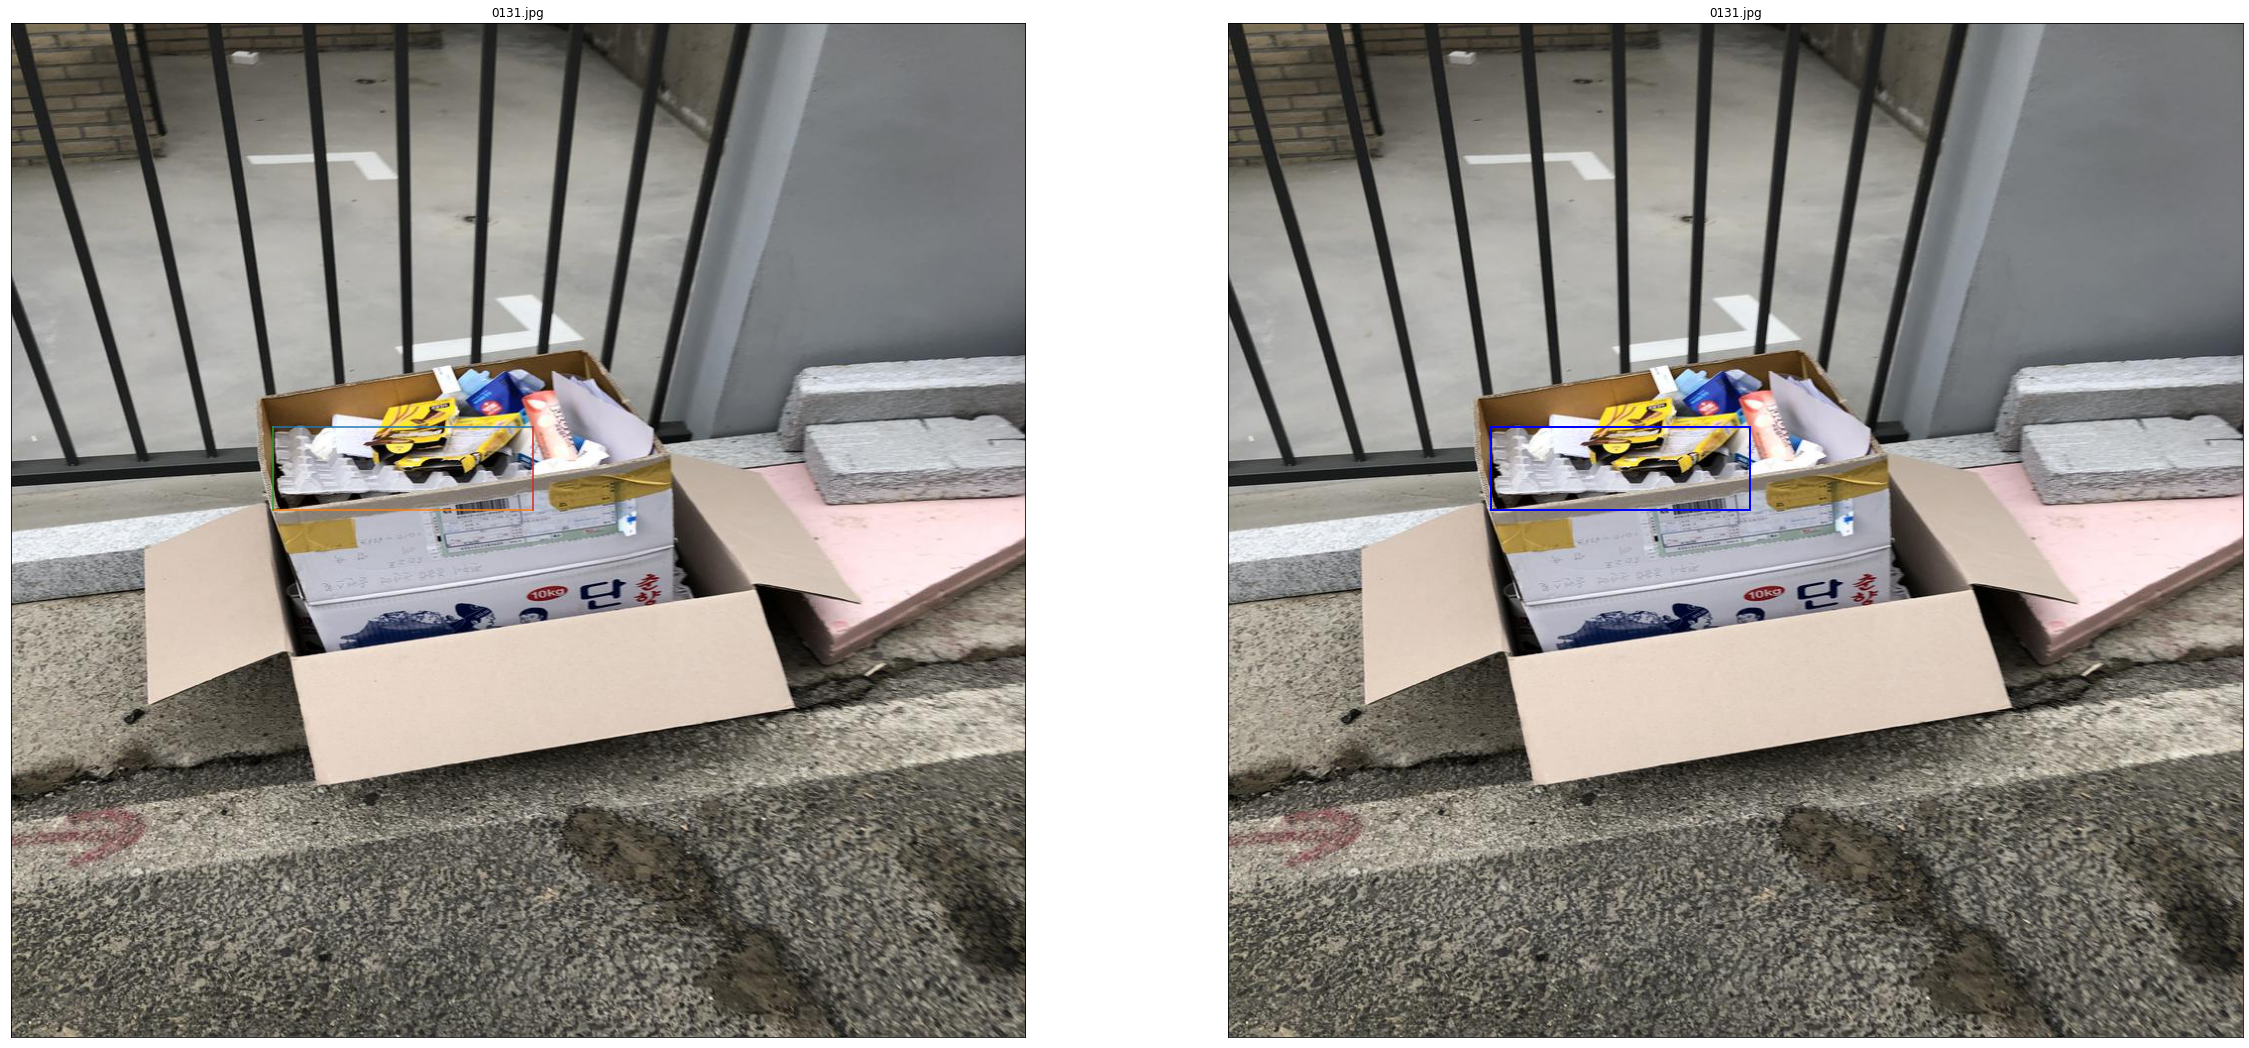

In [202]:
idx = 131
check_file_name = f"{idx:04d}.jpg"
img_idx = int(check_file_name.split(".")[0])
print(len(df_train[df_train["image_id"] == img_idx]["bbox"]))
x_min, y_min, width, height = df_train[df_train["image_id"] == img_idx]["bbox"].iloc[1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40, 40))
axes = axes.flatten()

axes[0].imshow(X=Image.open(os.path.join("/opt/ml/detection/dataset/train", check_file_name)))
axes[0].set_title(check_file_name)
axes[0].set_xticks([])
axes[0].set_yticks([])

x = [x_min, x_min + width]
y = [y_min, y_min]
axes[0].plot(x, y)

x = [x_min, x_min + width]
y = [y_min + height, y_min + height]
axes[0].plot(x, y)

y = [y_min, y_min + height]
x = [x_min, x_min]
axes[0].plot(x, y)

y = [y_min, y_min + height]
x = [x_min + width, x_min + width]
axes[0].plot(x, y)

# -----------------------

axes[1].imshow(X=Image.open(os.path.join("/opt/ml/detection/dataset/train", check_file_name)))
axes[1].set_title(check_file_name)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].add_patch(
    patches.Rectangle((x_min, y_min), 
                      width, height, 
                      fill=False,
                      edgecolor="blue",
                      linewidth=2)
)

# axes[1].set_visible(False)
plt.show()

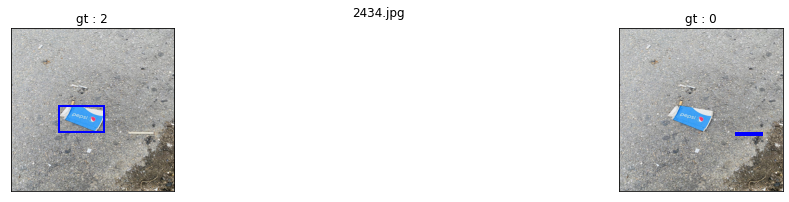

In [301]:
idx = 2434
check_file_name = f"{idx:04d}.jpg"
img_idx = int(check_file_name.split(".")[0])
num_bboxes = len(df_train[df_train["image_id"] == img_idx])
target_df = df_train[df_train["image_id"] == img_idx]

try:
    fig, axes = plt.subplots(nrows=1, ncols=num_bboxes, figsize=(20, 3))
    axes = axes.flatten()
    for idx, (x_min, y_min, width, height) in enumerate(target_df["bbox"]):
        category_id = target_df["category_id"].iloc[idx]
        axes[idx].imshow(X=Image.open(os.path.join("/opt/ml/detection/dataset/train", check_file_name)))
        axes[idx].set_title("\n".join(["gt : " + str(category_id)]))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        axes[idx].add_patch(
            patches.Rectangle((x_min, y_min), 
                              width, height, 
                              fill=False,
                              edgecolor="blue",
                              linewidth=2)
        )
except:
    fig, ax = plt.subplots(nrows=1, ncols=num_bboxes, figsize=(20, 3))
    # axes = axes.flatten()
    for idx, (x_min, y_min, width, height) in enumerate(target_df["bbox"]):
        # print(x_min, y_min, width, height)
        category_id = target_df["category_id"].iloc[idx]
        ax.imshow(X=Image.open(os.path.join("/opt/ml/detection/dataset/train", check_file_name)))
        ax.set_title("\n".join(["gt : " + str(category_id)]))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.add_patch(
            patches.Rectangle((x_min, y_min), 
                              width, height, 
                              fill=False,
                              edgecolor="blue",
                              linewidth=2)
        )

plt.suptitle(check_file_name)
plt.show()

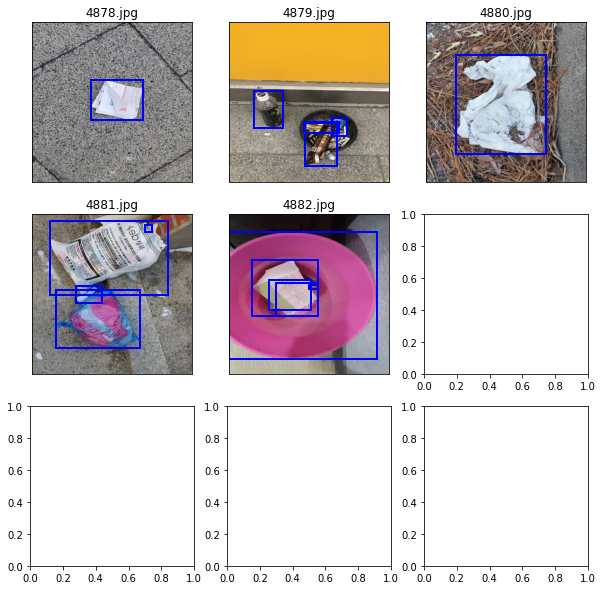

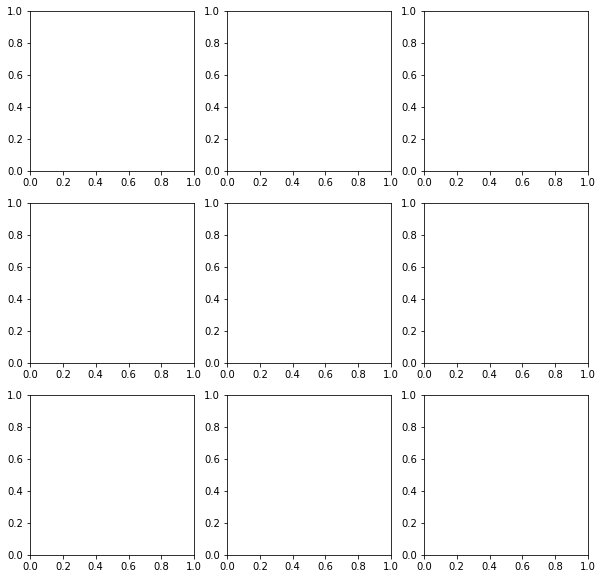

In [297]:
def get_pictures_with_all_bboxes(df_train, trigger:bool):
    min_image_idx, max_image_idx = min(df_train["image_id"]), max(df_train["image_id"])
    train_img_directory_path = "/opt/ml/detection/dataset/train"
    
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    axes = axes.flatten()
    
    dir_name_for_pic_with_all_bboxes = "/opt/ml/detection/#EDA/pic_with_all_bboxes_v1"
    if not os.path.exists(dir_name_for_pic_with_all_bboxes):
        os.mkdir(dir_name_for_pic_with_all_bboxes)
    
    if not trigger:
        return
    
    for img_idx in range(min_image_idx, max_image_idx + 1):
        check_file_name = f"{img_idx:04d}.jpg"
        # img_idx = int(check_file_name.split(".")[0])
        num_bboxes = len(df_train[df_train["image_id"] == img_idx])
        target_df = df_train[df_train["image_id"] == img_idx]

        axes_idx = img_idx % 9
        for i, (x_min, y_min, width, height) in enumerate(target_df["bbox"]):
            category_id = target_df["category_id"].iloc[i]
            axes[axes_idx].imshow(X=Image.open(os.path.join(train_img_directory_path, check_file_name)))
            axes[axes_idx].set_xticks([])
            axes[axes_idx].set_yticks([])
            axes[axes_idx].add_patch(
                patches.Rectangle((x_min, y_min), 
                                  width, height, 
                                  fill=False,
                                  edgecolor="blue",
                                  linewidth=2)
            )

            axes[axes_idx].set_title(check_file_name)

        if (img_idx + 1) % 9 == 0 or img_idx == max_image_idx:
            from_file_name = f"{img_idx-8:04d}"
            fig.savefig(fname=os.path.join(dir_name_for_pic_with_all_bboxes, from_file_name+ "_"+check_file_name),
                       dpi=200)
            # plt.tight_layout()
            # plt.show()
            fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
            axes = axes.flatten()
        
get_pictures_with_all_bboxes(df_train=df_train, trigger=False)
# df_train.iloc[0:60]

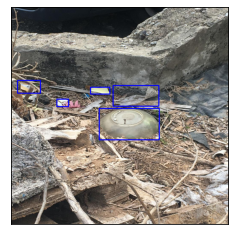

In [250]:
# Import Packages

import json
import random


import cv2
import matplotlib.pyplot as plt

# Define Functions

def get_file_path(json_file, image_num):
    file_path = json_file['images'][image_num]['file_name']
    return file_path


def get_annotations(json_file, image_num):
    anns = [ann for ann in json_file['annotations'] if ann['image_id'] == image_num]
    return anns


def read_image(dataset_path, file_path):
    image = cv2.imread(dataset_path + file_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def plot_bbox(image, anns):
    for ann in anns:
        xmin, ymin, w, h = map(int, ann['bbox'])
        image = cv2.rectangle(image, (xmin, ymin), (xmin + w, ymin + h), (0, 0, 255), 3)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

# Load Json File

with open('../dataset/train.json', 'r') as f:
    train_json = json.load(f)
    
dataset_path = '../dataset/'

# Plot Bounding Box

image_num = random.randint(0, len(train_json['images']) - 1)
file_path = get_file_path(train_json, image_num)
anns = get_annotations(train_json, image_num)
image = read_image(dataset_path, file_path)
plot_bbox(image, anns)

# 3. bbox 분포

In [48]:
df_train_bbox = df_train["bbox"]
df_train_bbox = pd.DataFrame([df_train_bbox.apply(lambda x: x[i]) for i in range(4)]).T
df_train_bbox.columns = ["x_min", "y_min", "width", "height"]
df_train_bbox["width/height"] = df_train_bbox["width"] / df_train_bbox["height"]
df_train_bbox["height/width"] = df_train_bbox["height"] / df_train_bbox["width"]
df_train_bbox["x_max"] = df_train_bbox["x_min"] + df_train_bbox["width"]
df_train_bbox["y_max"] = df_train_bbox["y_min"] + df_train_bbox["height"]

df_train_bbox.head()

,x_min,y_min,width,height,width/height,height/width,x_max,y_max
0,197.6,193.7,547.8,469.7,1.166276,0.857430,745.4,663.4
1,0.0,407.4,57.6,180.6,0.318937,3.135417,57.6,588.0
2,0.0,455.6,144.6,181.6,0.796256,1.255878,144.6,637.2
3,722.3,313.4,274.3,251.9,1.088924,0.918338,996.6,565.3
4,353.2,671.0,233.7,103.4,2.260155,0.442448,586.9,774.4


In [75]:
df_train_bbox.describe()

,x_min,y_min,width,height,width/height,height/width
count,23144.000000,23144.000000,23144.000000,23144.000000,23144.000000,23144.000000
mean,386.195653,382.230008,257.499170,252.241518,1.298707,1.207635
std,244.491114,217.282849,204.582362,200.143898,1.166790,0.986826
min,0.000000,0.000000,0.700000,0.800000,0.055391,0.036649
25%,200.100000,226.975000,99.750000,93.500000,0.691147,0.650489
50%,362.700000,370.500000,200.900000,196.100000,1.047518,0.954637
75%,553.325000,524.900000,357.650000,359.825000,1.537306,1.446871
max,1015.400000,1011.500000,1023.900000,1023.900000,27.285714,18.053571


In [90]:
offset = 1
df_train_bbox.sort_values(by="width/height", axis=0)[offset:-offset].describe()

,x_min,y_min,width,height,width/height,height/width
count,23142.000000,23142.000000,23142.000000,23142.000000,23142.000000,23142.000000
mean,386.189919,382.237019,257.499481,252.253794,1.297638,1.206958
std,244.496809,217.272898,204.578758,200.146363,1.154239,0.980606
min,0.000000,0.000000,0.700000,0.800000,0.059490,0.036682
25%,200.100000,227.000000,99.800000,93.500000,0.691173,0.650518
50%,362.700000,370.500000,200.900000,196.100000,1.047518,0.954637
75%,553.300000,524.900000,357.600000,359.875000,1.537237,1.446816
max,1015.400000,1011.500000,1023.900000,1023.900000,27.261111,16.809524


In [89]:
offset = 1
df_train_bbox.sort_values(by="height/width", axis=0)[offset:-offset].describe()

,x_min,y_min,width,height,width/height,height/width
count,23142.000000,23142.000000,23142.000000,23142.000000,23142.000000,23142.000000
mean,386.189919,382.237019,257.499481,252.253794,1.297638,1.206958
std,244.496809,217.272898,204.578758,200.146363,1.154239,0.980606
min,0.000000,0.000000,0.700000,0.800000,0.059490,0.036682
25%,200.100000,227.000000,99.800000,93.500000,0.691173,0.650518
50%,362.700000,370.500000,200.900000,196.100000,1.047518,0.954637
75%,553.300000,524.900000,357.600000,359.875000,1.537237,1.446816
max,1015.400000,1011.500000,1023.900000,1023.900000,27.261111,16.809524


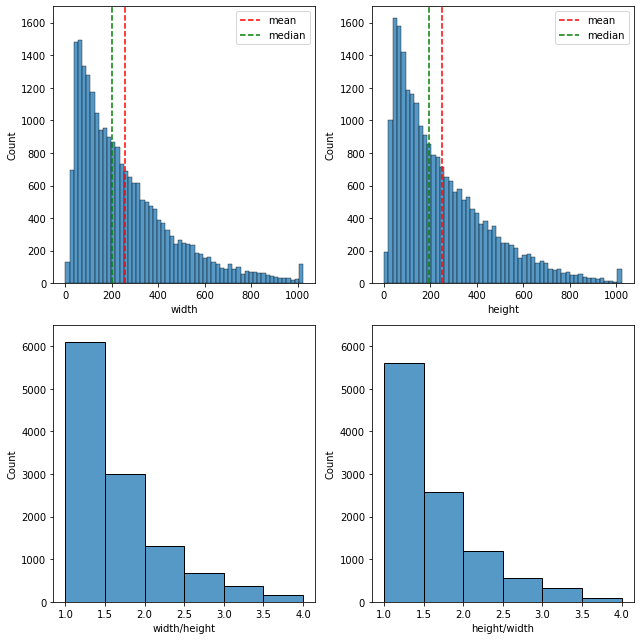

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
axes = axes.flatten()

offset = 600

sns.histplot(x="width",
             data=df_train_bbox,
             ax=axes[0])
width_mean_l, = axes[0].plot([df_train_bbox["width"].mean()]*2, [0, 1700], color="red", linestyle="--")
width_median_l, = axes[0].plot([df_train_bbox["width"].median()]*2, [0, 1700], color="green", linestyle="--")
axes[0].legend([width_mean_l, width_median_l], ["mean", "median"])
axes[0].set_ylim([0, 1700])

sns.histplot(x="height",
             data=df_train_bbox,
             ax=axes[1])
height_mean_l, = axes[1].plot([df_train_bbox["height"].mean()]*2, [0, 1700], color="red", linestyle="--")
height_median_l, = axes[1].plot([df_train_bbox["height"].median()]*2, [0, 1700], color="green", linestyle="--")
axes[1].legend([height_mean_l, height_median_l], ["mean", "median"])
axes[1].set_ylim([0, 1700])

data = df_train_bbox.sort_values(by="width/height", axis=0)[:-offset]
data = data[data["width/height"] >= 1.0]
sns.histplot(x="width/height",
             data=data,
             binwidth=0.5,
             ax=axes[2])
axes[2].set_ylim([0, 6500])

data = df_train_bbox.sort_values(by="height/width", axis=0)[:-offset]
data = data[data["height/width"] >= 1.0]
sns.histplot(x="height/width",
             data=data,
             binwidth=0.5,
             ax=axes[3])
axes[3].set_ylim([0, 6500])

plt.tight_layout()
plt.show()

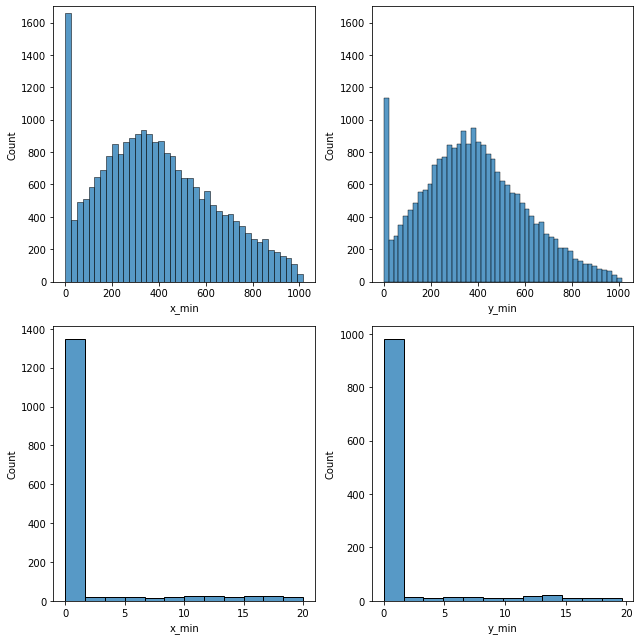

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
axes = axes.flatten()

sns.histplot(x="x_min",
             data=df_train_bbox,
             ax=axes[0])
axes[0].set_ylim([0, 1700])

sns.histplot(x="y_min",
             data=df_train_bbox,
             ax=axes[1])
axes[1].set_ylim([0, 1700])

sns.histplot(x="x_min",
             data=df_train_bbox[df_train_bbox["x_min"] <= 20],
             ax=axes[2])

sns.histplot(x="y_min",
             data=df_train_bbox[df_train_bbox["y_min"] <= 20],
             ax=axes[3])

plt.tight_layout()
plt.show()

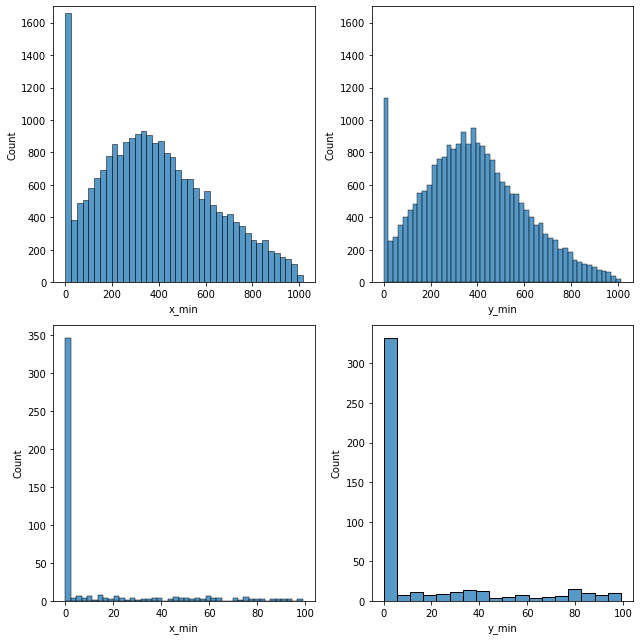

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
axes = axes.flatten()

sns.histplot(x="x_min",
             data=df_train_bbox,
             ax=axes[0])
axes[0].set_ylim([0, 1700])

sns.histplot(x="y_min",
             data=df_train_bbox,
             ax=axes[1])
axes[1].set_ylim([0, 1700])

sns.histplot(x="x_min",
             data=df_train_bbox[df_train_bbox["x_min"] + df_train_bbox["y_min"] <= 100],
             ax=axes[2])

sns.histplot(x="y_min",
             data=df_train_bbox[df_train_bbox["x_min"] + df_train_bbox["y_min"] <= 100],
             ax=axes[3])

plt.tight_layout()
plt.show()

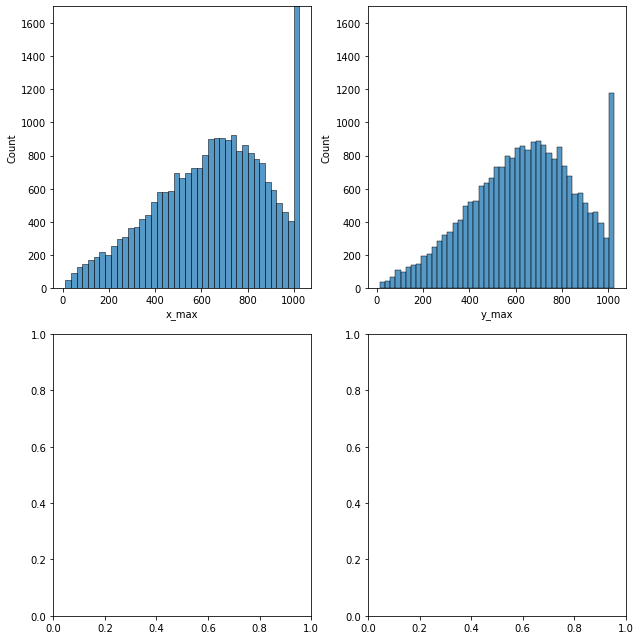

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
axes = axes.flatten()

sns.histplot(x="x_max",
             data=df_train_bbox,
             ax=axes[0])
axes[0].set_ylim([0, 1700])

sns.histplot(x="y_max",
             data=df_train_bbox,
             ax=axes[1])
axes[1].set_ylim([0, 1700])

# sns.histplot(x="x_min",
#              data=df_train_bbox[df_train_bbox["x_min"] + df_train_bbox["y_min"] <= 100],
#              ax=axes[2])

# sns.histplot(x="y_min",
#              data=df_train_bbox[df_train_bbox["x_min"] + df_train_bbox["y_min"] <= 100],
#              ax=axes[3])

plt.tight_layout()
plt.show()

# 4. Class 불균형 체크

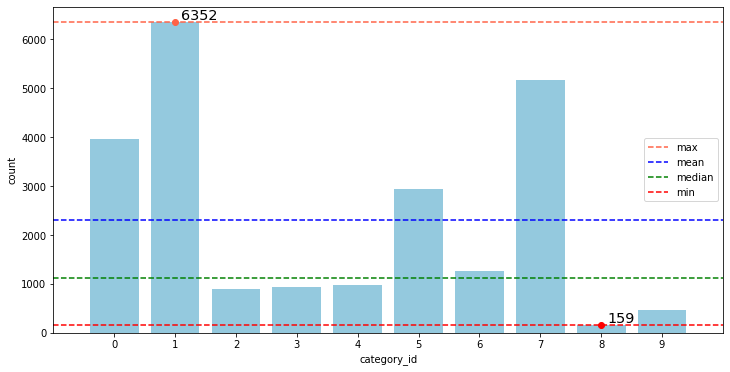

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

offset = 1

sns.countplot(x="category_id",
              data=df_train,
              ax=axes,
              color="skyblue")

mean_l, = axes.plot([-1, 10], [df_train["category_id"].value_counts().mean()]*2, color="blue", linestyle="--")
median_l, = axes.plot([-1, 10], [df_train["category_id"].value_counts().median()]*2, color="green", linestyle="--")
min_l, = axes.plot([-1, 10], [df_train["category_id"].value_counts().min()]*2, color="red", linestyle="--")
max_l, = axes.plot([-1, 10], [df_train["category_id"].value_counts().max()]*2, color="tomato", linestyle="--")

axes.plot([1], [df_train["category_id"].value_counts().max()], marker="o", color="tomato")
axes.plot([8], [df_train["category_id"].value_counts().min()], marker="o", color="red")

axes.text(1, df_train["category_id"].value_counts().max()+50, s=f"{df_train['category_id'].value_counts().max()}", fontsize="x-large")
axes.text(8, df_train["category_id"].value_counts().min()+50, s=f"{df_train['category_id'].value_counts().min()}", fontsize="x-large")

axes.set_xlim([-1, 10])
axes.legend([max_l, mean_l, median_l, min_l], ["max", "mean", "median", "min"])

plt.show()